In [46]:
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle
from time import time

### So, what I want to do is this:
- take an image
- break it up into rectangles twice as tall as they are high
    - each of these rectangles is going to be an ANSI formatted character
    - the ultimate goal of this is to convert an image into colored text that can be printed on a terminal
- for each rectangle, reduce the number of colors to two 
- find the shape that will fit best 
    - Jacobian or something like that 
    
### Complications:
- Where do we shrink?
- Is Jacobian too naive? Should we consider edges, etc. as well?

In [15]:
path = './dog/IMG_4697.JPG'

In [32]:
with open(path,'rb') as f:
    img = Image.open(f)
    img = np.asarray(img)
    img = img / 255

In [70]:
def display_image_array(img, reduce_factor: int=10):
    """ Input:
            img: a numpy array containing the image data. It's assumed that it's 
                already been divided by 255 (to make scikit-learn play nice with
                it).
            reduce: int - how much we want to reduce the size of the image
        Output:
            displays the image inline. Shrinks it so it's not too large (don't
            want to burn out your scroll wheel)
    
    This is just here so I don't have to retype it over and over again. The doc
    strings I feel the need to compulsively write defeat the purpose tho, hahaha
    """

    make_255 = lambda img: (img*255).astype(np.uint8) # converts back to int 0-255
    make_image
    display(
        Image.fromarray(
            np.rot90(
                make_255(img), axes=(1,0) # For some reason Pillow rotates 90º counter-
            )                             # clockwise when it makes an image an array
        ).reduce(reduce_factor)
    )

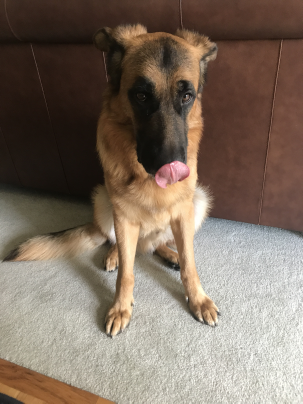

In [74]:
display(Image.fromarray(np.rot90( (img*255).astype(np.uint8), axes=(1,0)) ).reduce(10))

# Method 1:  color quantization using kmeans clustering
This example was taken more or less exactly from this example in the scikit-learn documentation:

https://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html

In [39]:
w,h,d = img.shape
w,h,d

(3024, 4032, 3)

In [40]:
n_colors = 16

In [48]:
image_array = np.reshape(img, (w * h, d))

In [49]:
print("Fitting model on a small sub-sample of the data")
t0 = time()
img_sample = shuffle(image_array, random_state=0, n_samples=1_000)
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(img_sample)
print(f"done in {time() - t0:0.3f}s.")

Fitting model on a small sub-sample of the data
done in 0.778s.


In [50]:
# Get labels for all points
print("Predicting color indices on the full image (k-means)")
t0 = time()
labels = kmeans.predict(image_array)
print(f"done in {time() - t0:0.3f}s.")

Predicting color indices on the full image (k-means)
done in 0.374s.


In [51]:
codebook_random = shuffle(image_array, random_state=0, n_samples=n_colors)
print("Predicting color indices on the full image (random)")
t0 = time()
labels_random = pairwise_distances_argmin(codebook_random, image_array, axis=0)
print(f"done in {time() - t0:0.3f}s.")

Predicting color indices on the full image (random)
done in 0.474s.


In [53]:
def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    return codebook[labels].reshape(w, h, -1)

new_img = recreate_image(kmeans.cluster_centers_, labels, w, h)

## Results:
I don't really like the results I got here, for a few reasons. 

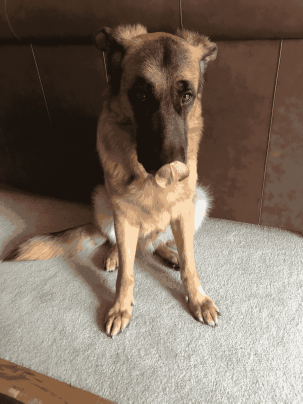

In [67]:
display(Image.fromarray(np.rot90((new_img*255).astype(np.uint8), axes=(1,0))).reduce(10))

As you can see, there's still a lot of fine structure that won't translate well to our ANSI art represenation. We've reduced the number of colors to 16, but all we've really done is make the image look duller. We've also lost some of the variance, the "pop" - the bright pink of the tongue has been made into a brown about the same color as the surrounding fur. 

I think the a big part of the problem is that we were operating at a global scale, but that's not where we're going to be operating. The total number of colors doesn't matter: what matters is that, once we divide the image into the rectangles that are going to be converted into ANSI formatted characters, each RECTANGLE must contain only two colors.

What we really want isn't to reduce the color pallete for the entire image, but to reduce the color pallete within the domain of a character sized rectangle.  